In [9]:
import sys
# sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.regression import load_esdc

# Feature Extraction/Transformations
from esdc.transform import DensityCubes
from src.features.classification import get_common_elements
from src.features.stats import calculate_regression_stats

# GP Models
from src.models.regression import gpr_naive, predict_batches
from src.models.derivatives import GPRDerivative
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Visualization
from esdc.visualize import plot_xarray_on_map, plot_map
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use(['seaborn-talk'])

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

For this experiment, we are going to be looking at the region of Europe for the duration of the year 2010. The variables in question are Gross Primary Productivity (GPP) and Land Surface Temperature (LST)

In [10]:
!ls /home/emmanuel/projects/2019_sakame/data/results/esdc/regression/

test_gross_primary_productivity_s3.nc	 trial1_land_surface_temperature_s10.nc
trial1_gross_primary_productivity_s2.nc  trial1_land_surface_temperature_s2.nc
trial1_gross_primary_productivity_s3.nc  trial1_land_surface_temperature_s3.nc
trial1_gross_primary_productivity_s4.nc  trial1_land_surface_temperature_s4.nc
trial1_gross_primary_productivity_s5.nc  trial1_land_surface_temperature_s5.nc
trial1_gross_primary_productivity_s6.nc  trial1_land_surface_temperature_s6.nc
trial1_gross_primary_productivity_s7.nc  trial1_land_surface_temperature_s7.nc
trial1_gross_primary_productivity_s8.nc  trial1_land_surface_temperature_s8.nc
trial1_gross_primary_productivity_s9.nc  trial1_land_surface_temperature_s9.nc


In [28]:
DATA_PATH = "/home/emmanuel/projects/2019_sakame/data/results/esdc/regression/"
FIGURE_PATH = "/home/emmanuel/projects/2019_sakame/reports/figures/esdc/regression/"
save_name = "trial1_gross_primary_productivity_s4.nc"

xr_results = xr.open_dataset(DATA_PATH + save_name)
xr_results

<xarray.Dataset>
Dimensions:      (lat: 140, lon: 291, time: 46)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lat          (lat) float64 62.62 64.38 63.38 39.38 ... 43.12 70.38 70.88
  * lon          (lon) float64 31.88 19.12 54.88 32.38 ... -16.62 -9.625 -14.12
Data variables:
    Predictions  (time, lat, lon) float64 ...
    Labels       (time, lat, lon) float32 ...
    Sensitivity  (time, lat, lon) float64 ...
    AE           (time, lat, lon) float64 ...
    SE           (time, lat, lon) float64 ...
Attributes:
    r2:          0.9212708823927621
    mae:         0.3363313971094109
    mse:         0.4800874845579367
    rmse:        0.6928834566923479
    train_size:  5000
    seed:        1
    spatial:     4

In [26]:
xr_results.coords['lon'] = xr_results.coords['lon'][::-1]
xr_results.coords['lat'] = xr_results.coords['lat'][::-1]

### Predictions

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


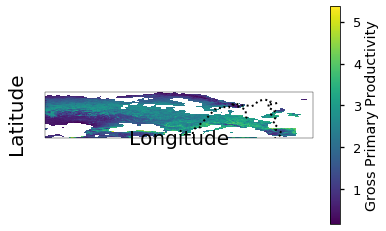

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


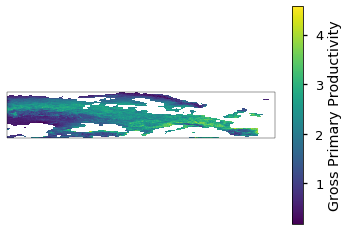

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

xr_results.Labels.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=True,
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)

ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')

# ax.coastlines(linewidth=2)
# ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.23, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "gpr_s3_labels.png"
fig.savefig(FIGURE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)
plt.show()

# =========================
# Predictions
# =========================
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

xr_results.Predictions.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=True,
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()

save_name = "gpr_s3_predictions.png"
fig.savefig(FIGURE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

plt.show()

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


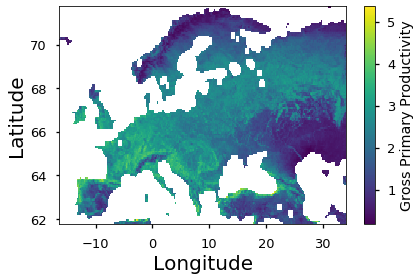

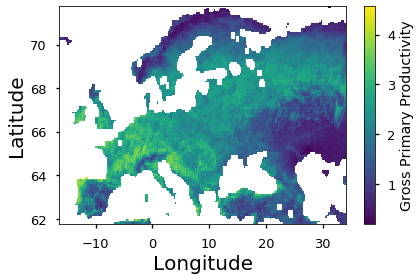

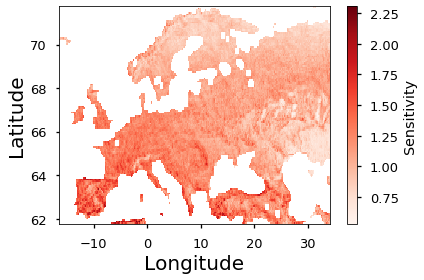

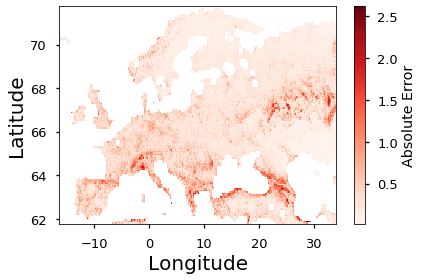

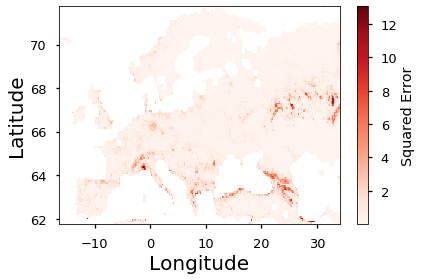

In [20]:
fig, ax = plot_map(
    xr_results.Labels.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()

save_name = "ee_svm_predictions.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)
plt.show()

fig, ax = plot_map(
    xr_results.Predictions.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Sensitivity.mean(dim='time'),
    cmap="Reds",
    cbar_kwargs = {'label':'Sensitivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.AE.mean(dim='time'),
    cmap="Reds",
#     robust=True,
    cbar_kwargs = {'label':'Absolute Error',}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.SE.mean(dim='time'),
    cmap="Reds",
#     robust=True,
    cbar_kwargs = {'label':'Squared Error'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()